Basic gramma / psycopg usage reference from Psycopg 2.9.3 documentation (https://www.psycopg.org/docs/usage.html)

### Section 1: Querying a database in python

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 1. Connect to local postgres instance
conn = psycopg2.connect(host="localhost",
                        database="dvdrental",
                        user="postgres",
                        password="password",
                        port = "5432")

In [3]:
# 2. Write a query to return a dataset with film, rental, and payment information. 
#     Your dataset should have multiple rows per film, one for each time the film was rented and the amount spent on each rental. 
#     Create a dataframe with this information

# Open a cursor to perform database operations
cur = conn.cursor()
# retrieve all necessary information
cur.execute("SELECT rental.rental_date, payment.amount, payment.customer_id, inventory.store_id, \
                    film.film_id, film.title, film.fulltext, film.rating, film_category.category_id, film.rental_rate \
                FROM rental LEFT JOIN payment USING(rental_id) \
                    LEFT JOIN inventory USING(inventory_id) \
                    LEFT JOIN film USING(film_id) \
                    LEFT JOIN film_category USING(film_id) \
                ORDER BY title")
# fetch results and convert to a Pandas dataframe
rentals = pd.DataFrame(cur.fetchall(), columns=["rental_date", "payment_amount", "customer_id", "store_id", \
                                                "film_id", "film_name", "fulltext", "rating", "category_id", "rental_rate"])
rentals["payment_amount"] = rentals["payment_amount"].astype("float")
rentals["rental_rate"] = rentals["rental_rate"].astype("float")
rentals.head()

,rental_date,payment_amount,customer_id,store_id,film_id,film_name,fulltext,rating,category_id,rental_rate
0,2005-06-15 02:57:51,0.99,345.0,2,1,Academy Dinosaur,'academi':1 'battl':15 'canadian':20 'dinosaur...,PG,6,0.99
1,2005-08-02 00:47:19,0.99,301.0,1,1,Academy Dinosaur,'academi':1 'battl':15 'canadian':20 'dinosaur...,PG,6,0.99
2,2005-08-22 00:44:08,0.99,92.0,2,1,Academy Dinosaur,'academi':1 'battl':15 'canadian':20 'dinosaur...,PG,6,0.99
3,2005-08-22 23:56:37,0.99,541.0,1,1,Academy Dinosaur,'academi':1 'battl':15 'canadian':20 'dinosaur...,PG,6,0.99
4,2005-06-17 20:24:00,0.99,170.0,1,1,Academy Dinosaur,'academi':1 'battl':15 'canadian':20 'dinosaur...,PG,6,0.99


In [4]:
# 3. Create a dataframe from the customer table

# retrieve all customer information
cur.execute("SELECT * FROM customer")
# fetch results and convert to a Pandas dataframe
customers = pd.DataFrame(cur.fetchall(), columns=["customer_id", "store_id", \
                                                  "first_name", "last_name", "email", "address_id", \
                                                  "activebool", "create_date", "last_update", "active"])

### Section 2: Manipulating dataframes

In [5]:
 # 1. Create a column for customer_name that has the first name and last name in the same column.
customers["customer_name"] = customers["first_name"] + " " + customers["last_name"] 

In [6]:
# 2. Remove any inactive customers from the dataframe
active_customers = customers[(customers["active"] == 1)].copy()

In [7]:
# 3. Change the email addresses to be ‘joe.person@wustl.edu’, but only when their store_id is an even number
active_customers["email"] = active_customers.apply(lambda x: "joe.person@wustl.edu" if (x["store_id"] %2 == 0) else x["email"], axis = 1 )

### Section 3: Visualizations

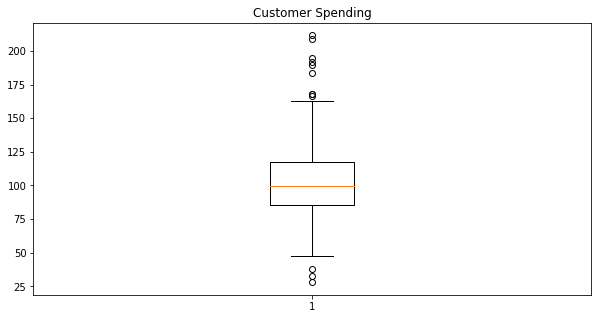

In [8]:
# 1. How much do customers tend to spend on rentals in aggregate?
customer_payments = rentals.groupby("customer_id")["payment_amount"].sum()

plt.figure(figsize = (10,5))
plt.title(label='Customer Spending')
plt.boxplot(customer_payments)
plt.show()

*Most customers spend between \\$80 and \\$115. The highest amount paid is around \\$210, and the least amount paid is around \\$27. The average of customer payment is around \\$102.*

<Figure size 432x288 with 0 Axes>

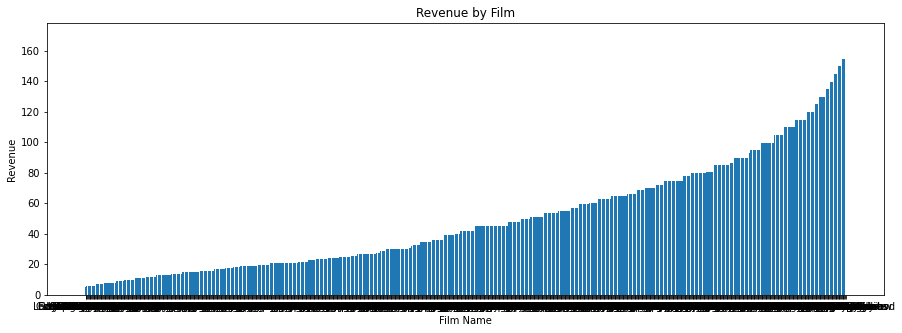

In [9]:
# 2. What does the distribution of film revenue look like?
film_revenue = pd.DataFrame(rentals.groupby("film_name").apply(lambda x:x["rental_rate"].mean()*x["rental_date"].\
                                                               count())).reset_index().rename(columns={0: "revenue"})

# visual 1: bar chart 
plt.clf()
plt.figure(figsize = (15,5))
plt.bar(film_revenue.sort_values("revenue")["film_name"], height = film_revenue.sort_values("revenue")["revenue"])
plt.title(label='Revenue by Film')
plt.xlabel("Film Name")
plt.ylabel("Revenue")
plt.show()

(array([268., 182., 145., 123.,  97.,  52.,  50.,  21.,  14.,   6.]),
 array([  4.95 ,  21.421,  37.892,  54.363,  70.834,  87.305, 103.776,
        120.247, 136.718, 153.189, 169.66 ]),
 <BarContainer object of 10 artists>)

<Figure size 432x288 with 0 Axes>

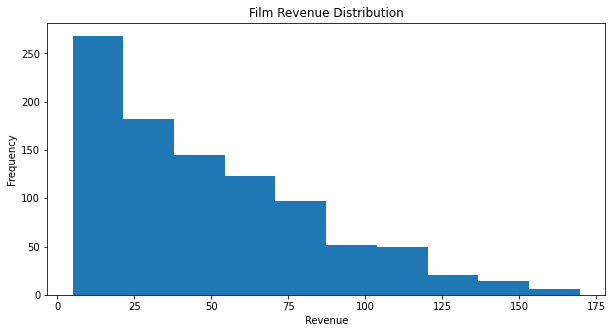

In [10]:
# visual 2: histogram
plt.clf()
plt.figure(figsize = (10,5))
plt.title(label='Film Revenue Distribution')
plt.subplot().set_ylabel("Frequency") 
plt.subplot().set_xlabel("Revenue")
plt.hist(film_revenue["revenue"])

*Most revenue are around 0-25. Lower frequency as the revenue goes up.*

*Since there are situations where payment amount is greater than rental rate, I believe it is more accurate to use the sum of payment amount as the revenue for films. The following visual is a histogram of film revenue based on payment amount.*

(array([159., 243., 182., 155.,  99.,  58.,  41.,  13.,   5.,   3.]),
 array([  5.94 ,  26.921,  47.902,  68.883,  89.864, 110.845, 131.826,
        152.807, 173.788, 194.769, 215.75 ]),
 <BarContainer object of 10 artists>)

<Figure size 432x288 with 0 Axes>

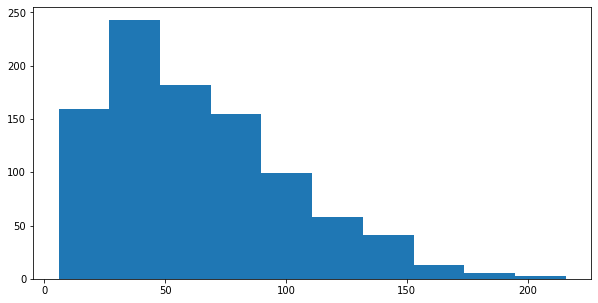

In [11]:
# histogram: revenue from sum of payment amount
film_amount = rentals.groupby("film_name")["payment_amount"].sum()

plt.clf()
plt.figure(figsize = (10,5))
plt.hist(film_amount)

### Section 4: Analysis

<Figure size 432x288 with 0 Axes>

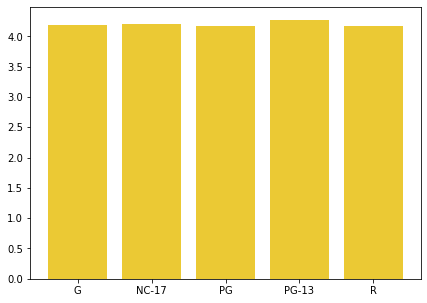

In [12]:
#1. On average, do some movie ratings generate more revenue than others?
rating_revenue =  rentals.groupby("rating")["payment_amount"].mean()

plt.clf()
plt.figure(figsize = (7,5))
plt.bar(x = rating_revenue.index, height = rating_revenue, color = "#ebc934")
plt.show()

*Five moving ratings have pretty similar revenue on average. It suggests that no movie rating is generating significantly larger revenue than others.*  

<Figure size 432x288 with 0 Axes>

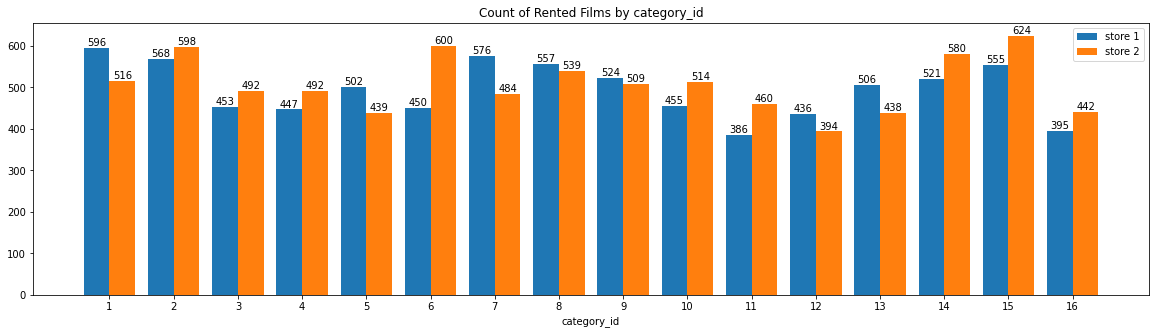

In [13]:
#2. Do distributions of counts of rented films by category_id look the same for the 2 stores?

store1_category = rentals.loc[rentals["store_id"]==1, :].groupby("category_id")["film_id"].count()
store2_category = rentals.loc[rentals["store_id"]==2, :].groupby("category_id")["film_id"].count()

# clustered bar chart reference from Matplotlib documentation (https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html)
plt.clf()
fig, ax = plt.subplots(figsize=(20,5))
x = store1_category.index
width = 0.4
s1 = ax.bar(x- width/2, store1_category, width, label='store 1')
s2 = ax.bar(x+ width/2, store2_category, width, label='store 2')

ax.bar_label(s1)
ax.bar_label(s2)

ax.set_title('Count of Rented Films by category_id')
ax.set_xlabel("category_id")
ax.set_xticks(x)
ax.legend()

plt.show()

*The distributions of counts of rented films by category_id look similar for the 2 stores, with no significant difference.* 

In [14]:
#3. Do films that have a ‘husband’ (check the ‘fulltext’ field) generate the same amount of revenue as films that feature a ‘dinosaur’?
rental2 = rentals.copy()
rental2["husband"] = rental2["fulltext"].apply(lambda x: 1 if "husband" in x.lower() else 0)
rental2["dinosaur"] = rental2["fulltext"].apply(lambda x: 1 if "dinosaur" in x.lower() else 0)

In [15]:
husband_films = rental2.loc[rental2["husband"]==1, "payment_amount"]
dinosaur_films = rental2.loc[rental2["dinosaur"]==1, "payment_amount"]

In [16]:
print('Revenue for films that feature a "husband":', round(husband_films.sum(), 3), \
      '\nRevenue for films that feature a "dinosaur":', round(dinosaur_films.sum(), 3), \
     '\nDifference: ', round(husband_films.sum()-dinosaur_films.sum(), 3))

Revenue for films that feature a "husband": 5553.49 
Revenue for films that feature a "dinosaur": 223.39 
Difference:  5330.1


*Films that have a "husband" generate much more revenue than films that feature a "dinosaur". The difference is as high as \\$5330.1.*